[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/034_rnn_intro/rnn_intro.ipynb)

# Redes Neuronales Recurrentes

En posts anteriores hemos cubierto muchísimos temas relacionados con `redes neuronales`, sin embargo en todos los ejemplos y aplicaciones hemos usado siempre la misma `arquitectura` de red neuronal: el `Perceptrón Multicapa` (MLP), un modelo del que hemos hablado extensivamente.

![](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)

En este modelo tenemos una serie de capas, cada capa formada por un número determinado de `perceptrones` (o neuronas artificiales, la unidad básica que forma las `redes neuronales` de la que también hemos hablado en gran cantidad en posts anteriores). Si bien este modelo es muy útil y potente, lo hemos utilizado por ejemplo para clasificar imágenes, existen otras aplicaciones para las cuales esta arquitectura se ve limitada. Una familia de aplicaciones en las que nuestro `MLP` no será muy efectivo es aquellas en las que tratemos con `datos secuenciales`, como por ejemplo `series temporales` o aplicaciones de `lenguaje` en las que nuestros datos están organizados en secuencias de longitud variable. En este post vamos a introducir una nueva `arquitectura` diseñada específicamente para tratar con datos secuenciales: las `redes neuronales recurrentes` (RNNs).

## Definición

En una red neuronal *feed forward* la información solo fluye en una dirección, desde la capa de entrada hasta la salida. Nuestro `MLP` es un ejemplo de este tipo de redes. Una `red recurrente` es muy similar a un `MLP` en el que además tenemos conexiones apuntando hacia detrás.

![](https://miro.medium.com/max/2544/1*aIT6tmnk3qHpStkOX3gGcQ.png)

En la imágen anterior tienes un ejemplo de la `RNN` más sencilla que existe, en la que sólo tenemos una entrada, una neurona en la capa oculta y una salida. En el caso del `MLP` calcularíamos la salida con la siguiente fórmula

$$ \mathbf{y} = \mathbf{W}_y \mathbf{h} = \mathbf{W}_y f(\mathbf{W}_x \mathbf{x}) $$

Sin embargo, en una `RNN` además de las entradas que ya conocemos, $x$, introduciremos las salidas de la capa oculta en el instante anterior, $h$, como entradas adicionales, las cuales irán multiplicadas por su propia matriz de pesos

$$ \mathbf{y}_t = \mathbf{W}_y \mathbf{h}_t = \mathbf{W}_y f(\mathbf{W}_x \mathbf{x}_t + \mathbf{W}_h \mathbf{h}_{t-1}) $$

En los ejemplos que hemos visto anteriormente, cada muestra en el dataset estaba caracterizado por un número determinado de características (por ejemplo, para clasificar imágenes, cada entrada correspondía al valor de cada píxel de la imagen). Sin embargo, al trabajar con datos secuenciales, nuestro dataset estará formado por secuencias de elementos, cada uno de ellos caracterizado por un número determinado de características (para seguir con el ejemplo de imágenes, podrías considerar un vídeo en el cada elemento sería un frame, una imagen). Denotaremos a cada elemento de la secuencia como $\mathbf{x}_t$ donde $\mathbf{x}$ es el vector de características del elemento en la secuencia $t$.

## Tipos de RNNs


Esta nueva arquitectura abre un nuevo mundo de posibilidades en el que podemos llevar a cabo nuevas tareas dependiendo de la configuración de entradas/salidas que utilicemos

![](https://i.stack.imgur.com/b4sus.jpg)

La tipología *one-to-one* corresponde al `MLP`, puedes considerarlo como una secuencia de longitud 1, el resto de tipologías nos permiten tareas como clasificación de secuencias o regresión a un valor (*many-to-one*) o regresión a varios valores futuros (*many-to-many*). En futuros posts veremos ejemplos de estas arquitecturas para llevar a cabo distintas tareas.

## Entrenando RNNs

Para entrenar `RNNs` utilizaremos exactamente el mismo algoritmo que hemos utilizado hasta ahora: el algoritmo de *bakpropagation*. Ahora, sin embargo, hay que tener en cuenta que podemos tener gradientes fluyendo desde cualquiera de las salidas de la red neuronal, por lo que en un mismo paso de actualización es posible actualizar los pesos con (potencialmente) muchos gradientes distintos. Esto puede resultar en ciertos problemas durante el entrenamiento de los que hablaremos más adelante.

![](https://s3.ap-south-1.amazonaws.com/techleer/191.png)

Obviamente, en los frameworks de `redes neuronales` que ya conocemos esto ya está implementado por lo que no tenemos que preocuparnos.

## Predicción de series temporales

Muy bien, en este punto ya sabemos qué es una `red neuronal recurrente` así que vamos a aplicarlo a una de sus principales aplicaciones que también no servirá para asentar los conceptos explicados anteriormente. Vamos a empezar generando una colección de series temporales de datos sintéticos.

In [ ]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [ ]:
print (series)

[[[ 0.03734893]
  [-0.0518217 ]
  [-0.2692368 ]
  ...
  [-0.2811124 ]
  [-0.50658995]
  [-0.63594955]]

 [[-0.2510853 ]
  [-0.27960202]
  [-0.38915867]
  ...
  [-0.40446565]
  [-0.30699456]
  [-0.3170263 ]]

 [[ 0.21305896]
  [ 0.22220981]
  [ 0.38440183]
  ...
  [ 0.2895369 ]
  [ 0.21108098]
  [ 0.10233395]]

 ...

 [[ 0.5287132 ]
  [ 0.52678835]
  [ 0.37289998]
  ...
  [ 0.687973  ]
  [ 0.5487158 ]
  [ 0.27166775]]

 [[-0.06012658]
  [ 0.203179  ]
  [ 0.46292573]
  ...
  [-0.4650568 ]
  [-0.5749552 ]
  [-0.63406557]]

 [[ 0.08335976]
  [ 0.01424113]
  [-0.22783679]
  ...
  [ 0.59190947]
  [ 0.6736215 ]
  [ 0.6252763 ]]]


Nuestro objetivo será el de predecir el último valor de la serie temporal a partir de todos los anteriores. De ser capaces de llevar a cabo esta tarea podríamos predecir, por ejemplo, la evolución de usuarios en una aplicación o web, el precio de las acciones de una empresa en bolsa, etc.

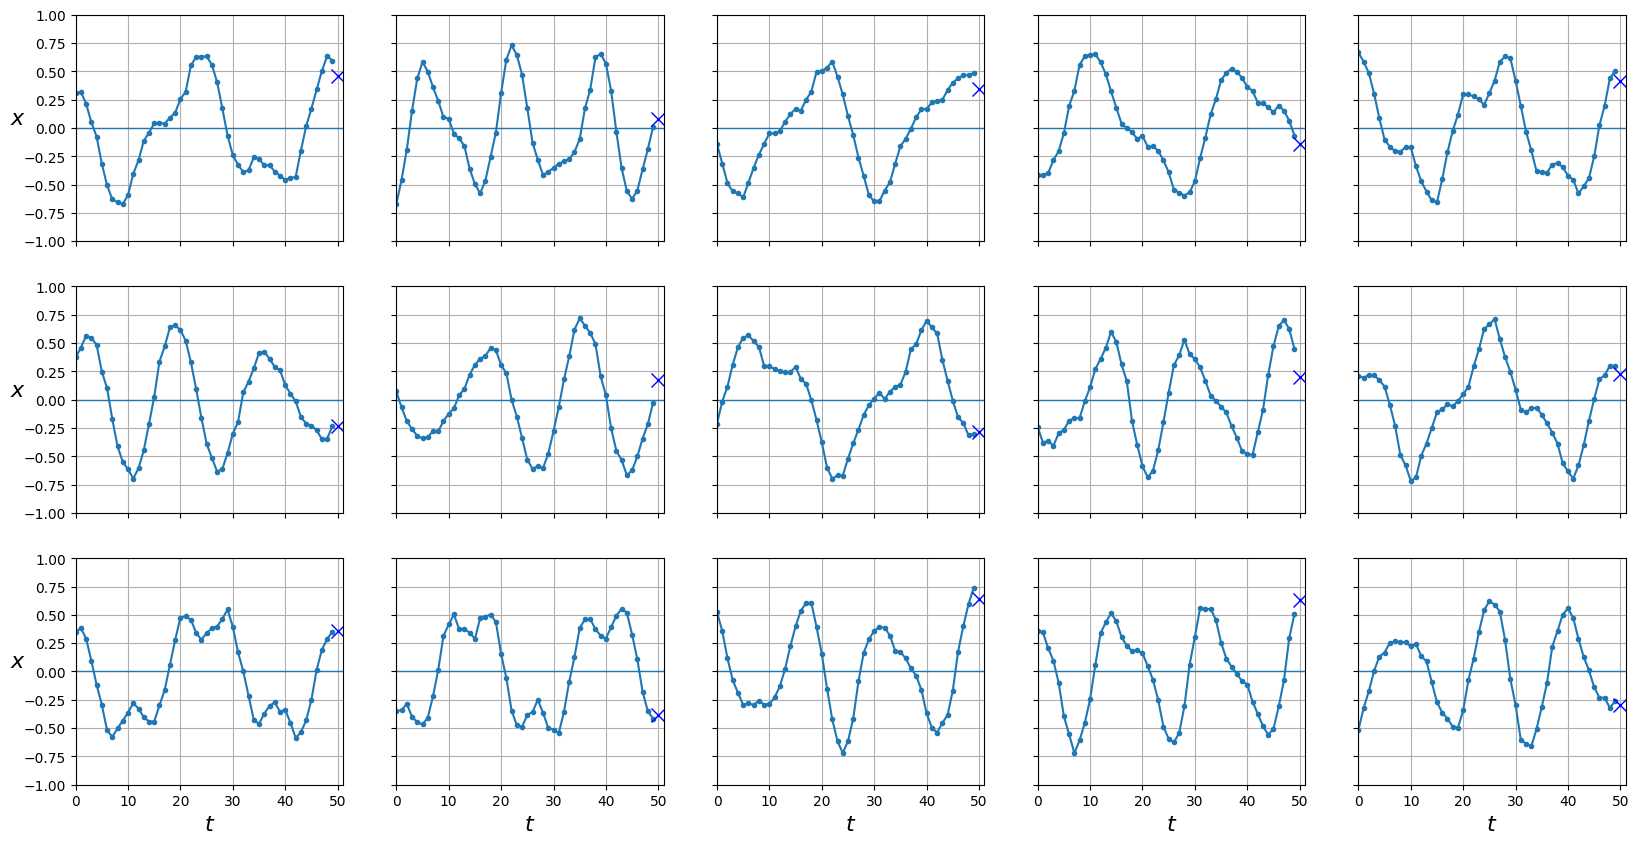

In [ ]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

### Predicción *Naive*

Un modelo muy simple y que puede funcionar sorprendentemente bien en algunas ocasiones es uno que siempre prediga el último valor.

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = X_test[:,-1]
mean_squared_error(y_test, y_pred)

0.0199082

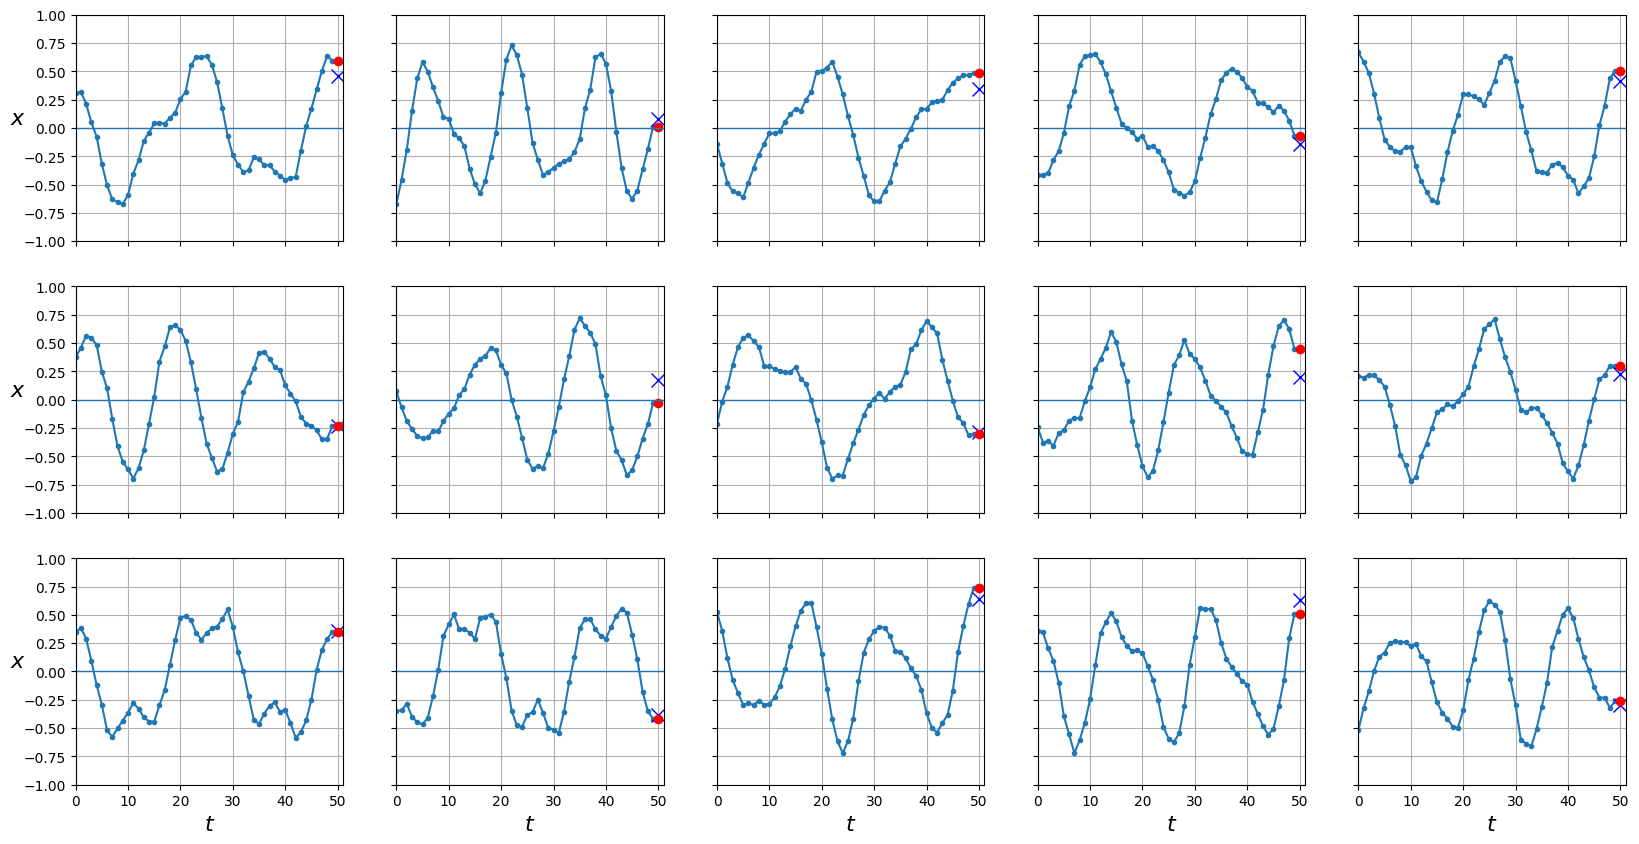

In [ ]:
y_pred = X_test[:,-1]
plot_series(X_test, y_test, y_pred)

Como puedes ver este modelo simple es bastante potente a la hora de predecir un único valor a partir de todos los anteriores.

### Perceptrón Multicapa

En el caso de que todas las secuencias tengan la misma longitud (lo cual no siempre es el caso) podríamos utilizar un `MLP` como los que ya conocemos para la tarea de regresión.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

mlp = MLP()
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
fit(mlp, dataloader)

loss 0.00673 val_loss 0.00655: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


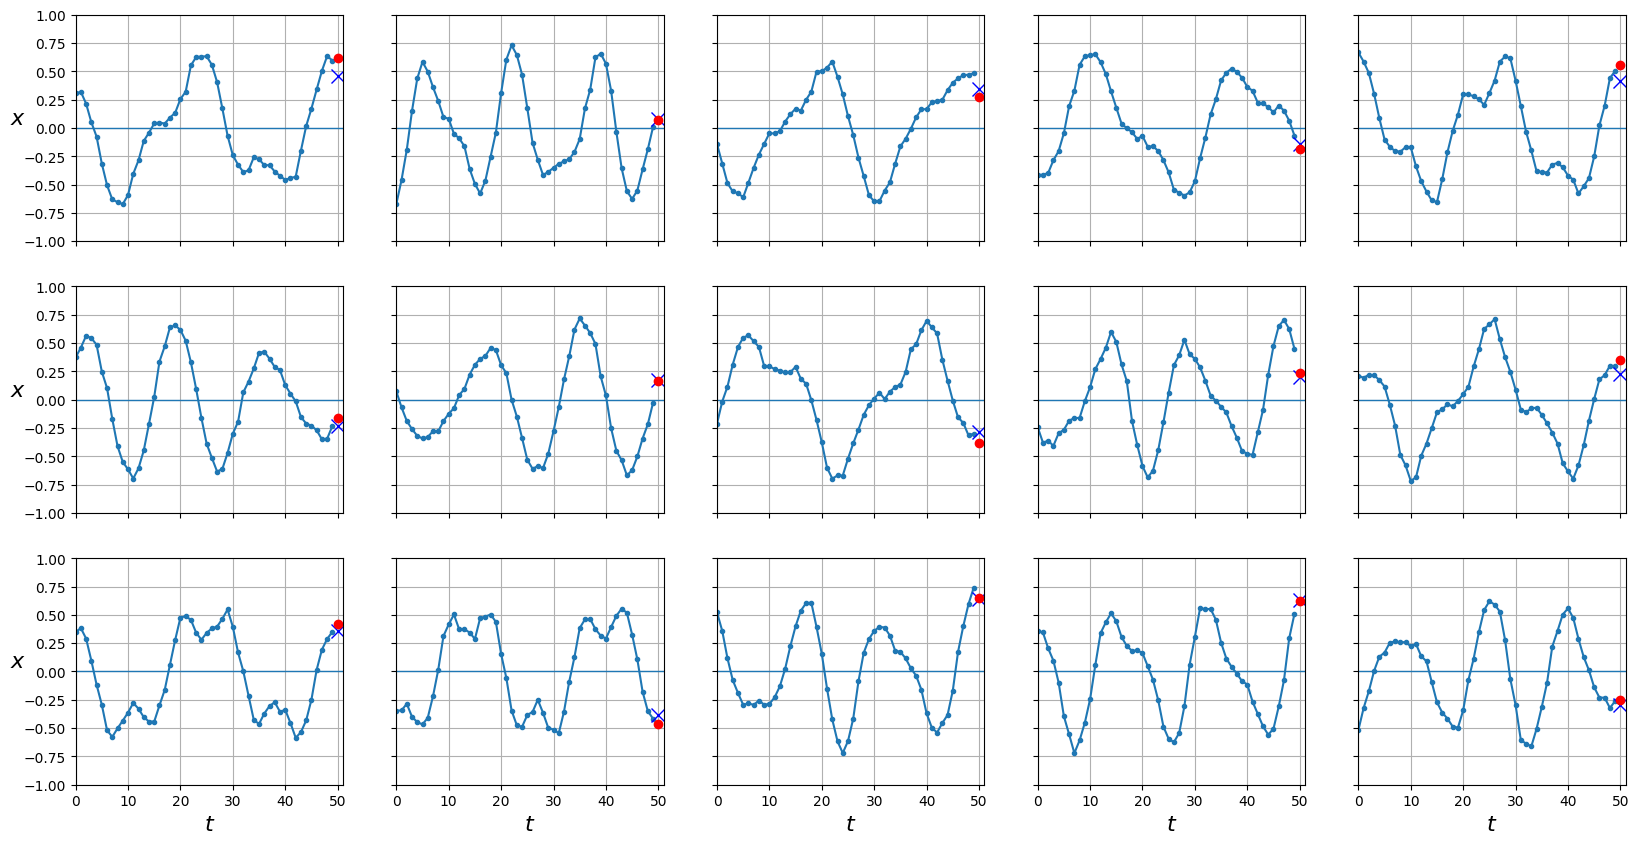

0.006540669

In [ ]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

Nuestro `preceptrón` es capaz de predecir con mejor precisión el último valor en una serie temporal a partir del resto. Vamos ahora a ver cómo hacer lo mismo con una `red recurrente`.

### Red Recurrente Simple

En `Pytorch` tenemos disponible la capa `torch.nn.RNN` que implementa la arquitectura de red neuronal recurrente que hemos presentado anteriormente. A esta capa le podemos pasar como parámetros, entre otros, el número de entradas, el número de neuronas en la capa oculta, el número de capa ocultas, etc. Poco a poco iremos viendo las diferentes opciones. Vamos a empezar con una `RNN` simple que acepta un solo valor a la entrada, una capa oculta de una sola neurona, y un valor a la salida (igual a la figura siguiente)

![](https://miro.medium.com/max/2544/1*aIT6tmnk3qHpStkOX3gGcQ.png)

In [ ]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1]

rnn = SimpleRNN()

In [ ]:
fit(rnn, dataloader)

loss 0.16141 val_loss 0.15365: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


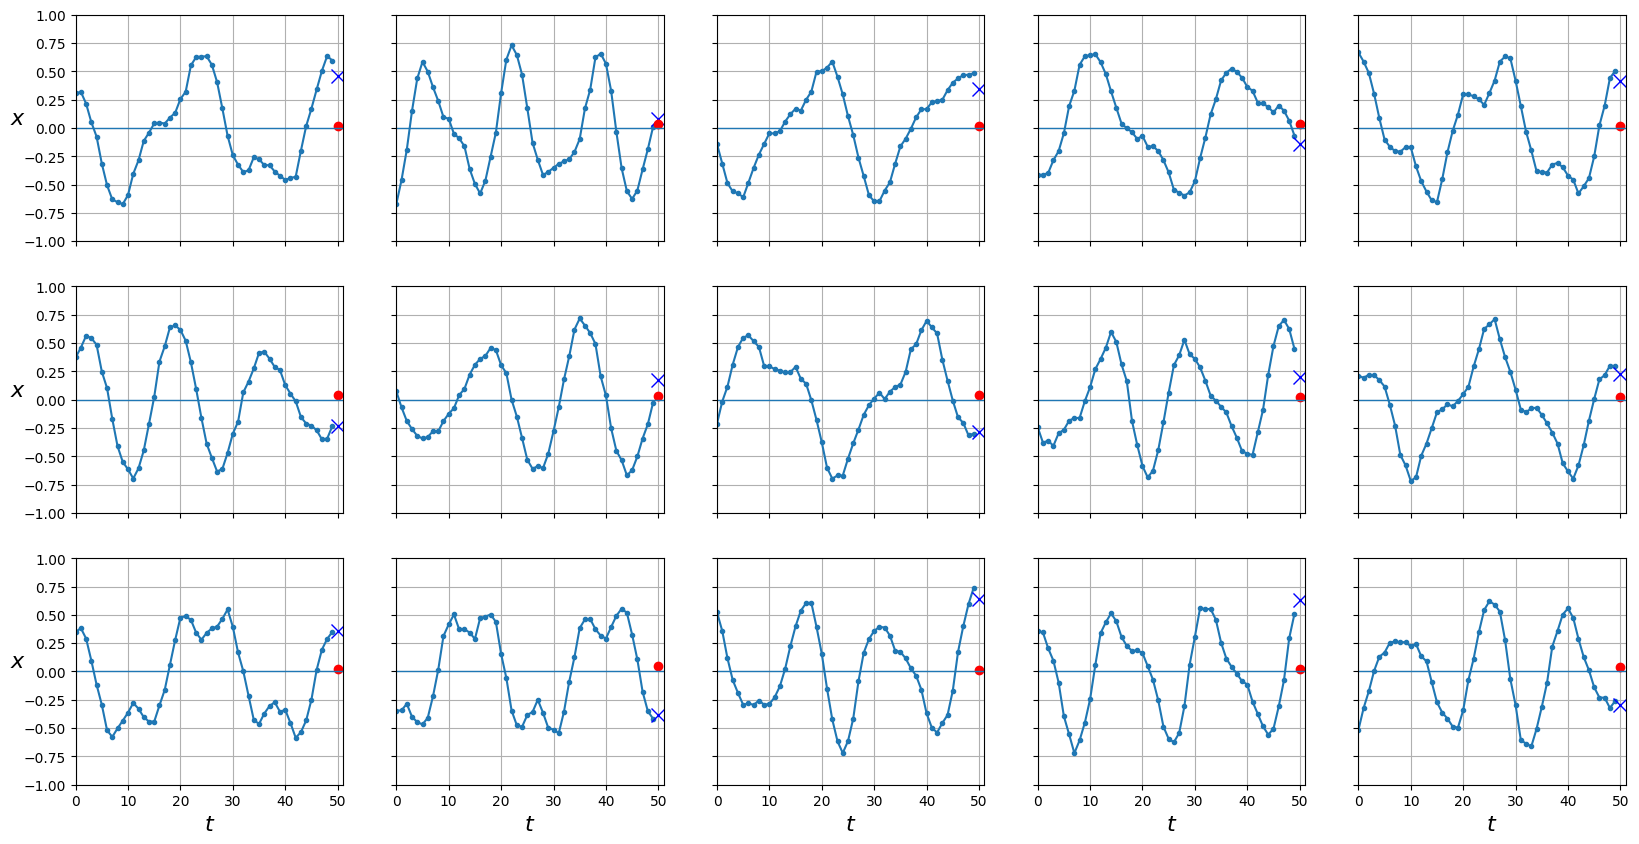

0.15329748

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

Según parece nuestra `RNN` no funciona mejor que el perceptrón anterior. ¿Cómo es posible si hemos dicho que las `redes recurrentes` funcionan mejor para datos secuenciales? La respuesta está en el número de parámetros de cada modelo.

In [ ]:
# parámetros en el MLP

mlp.fc.weight.shape, mlp.fc.bias.shape

(torch.Size([1, 50]), torch.Size([1]))

En el `MLP` tenemos 50 entradas conectadas a una salida, en total 50 parámetros más el bias, 51.

In [ ]:
# parámetros en la RNN simple

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape

(torch.Size([1, 1]), torch.Size([1, 1]), torch.Size([1]), torch.Size([1]))

En la `RNN` tenemos una entrada conecta a una neurona en la capa oculta (que al tener solo una capa oculta también es la salida), un peso más el bias, 2. Además, tenemos una conexión de la neurona en la capa oculta en un instante a la capa oculta en el instante siguiente, otro peso más el bias, 2 más. En total 4 parámetros contra los 51 del `MLP`. Necesitamos una `RNN` con más capacidad, por ejemplo aumentando el número de neuronas en la capa oculta. Para este caso, además, necesitaremos una capa lineal que nos de el último valor a partir de los 20 valores en la capa oculta.

In [ ]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(40, 1)

  def forward(self, x):
    x, h = self.rnn(x)
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [ ]:
# parámetros en la nueva RNN

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape, rnn.fc.weight.shape, rnn.fc.bias.shape

(torch.Size([40, 40]),
 torch.Size([40, 1]),
 torch.Size([40]),
 torch.Size([40]),
 torch.Size([1, 40]),
 torch.Size([1]))

In [ ]:
fit(rnn, dataloader)

loss 0.00385 val_loss 0.00359: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


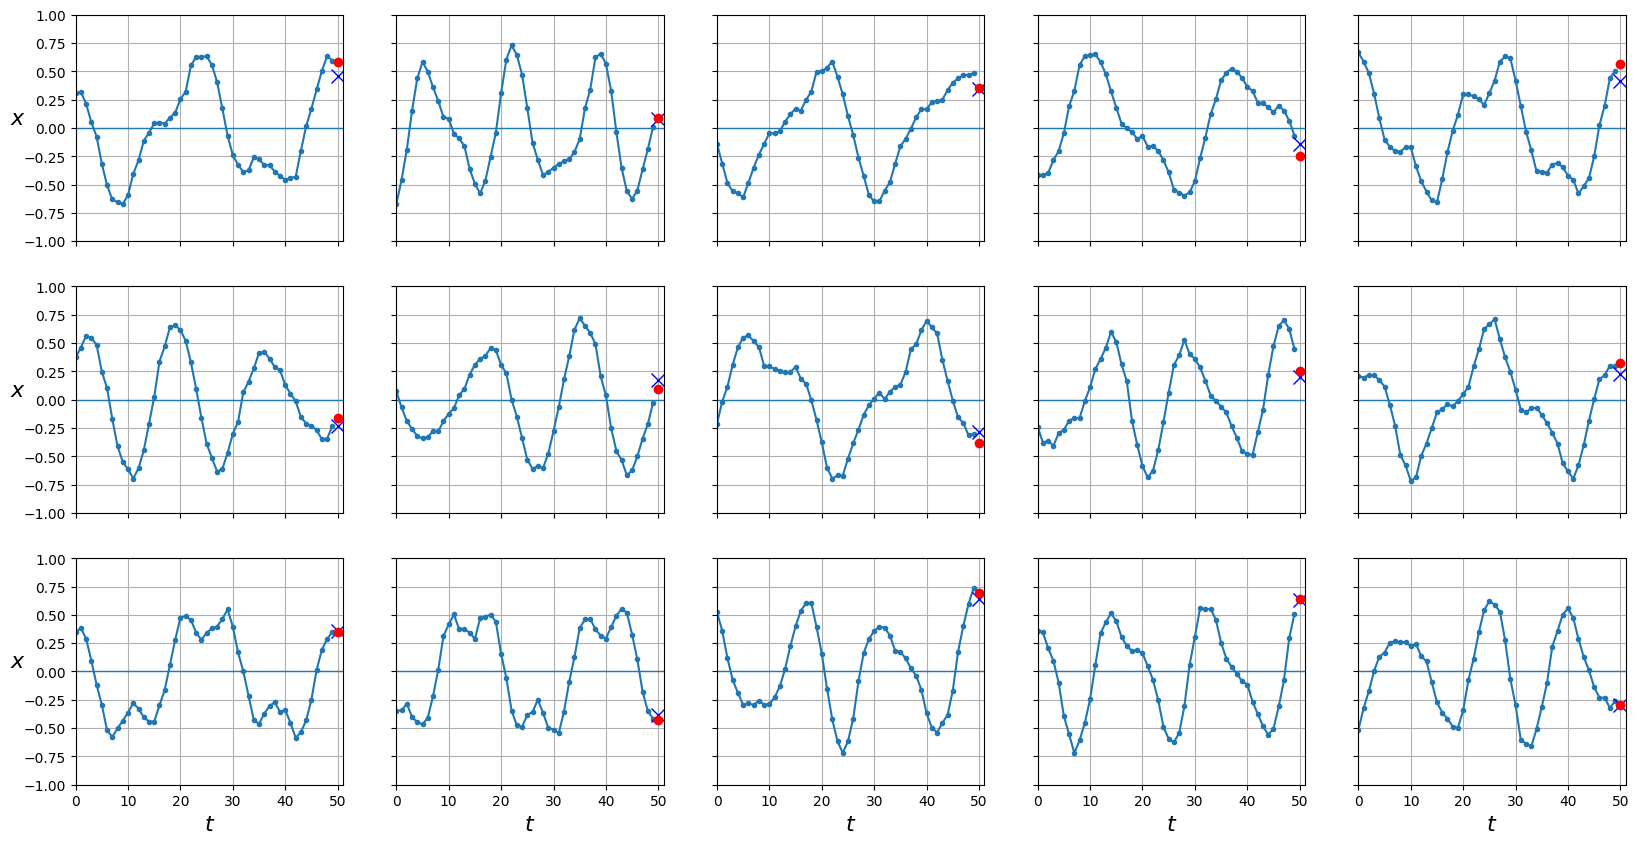

0.0036279154

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

Ahora sí, nuestra `RNN` tiene un poder similar al `MLP`. La diferencia es que el `MLP` recibe a la entrada todos los valores a la vez para generar la única salida, mientras que la `RNN` recibe los valores de 1 en 1, generando una salida en cada instante de las cuales nos quedamos con la última. Si nuestras secuencias fuesen de diferente longitud, no podríamos aplicar el `MLP` mientras que la `RNN` funcionaría sin problemas.

![](https://www.simplilearn.com/ice9/free_resources_article_thumb/Fully_connected_Recurrent_Neural_Network.gif)

## Resumen

En este post hemos introducido una nueva arquitectura de `red neuronal` que nos va a permitir trabajar con datos secuenciales: la `red neuronal recurrente`. Esta arquitectura es muy similar a la del `Perceptrón Multicapa` que ya conocemos de posts anteriores, en la que en cada capa oculta no solo tenemos conexiones a las entradas de la capa anterior si no también a los valores de la misma capa oculta pero en el instante anterior. De esta manera seremos capaces de llevar a cabo tareas de regresión y clasificación con datos secuenciales como series temporales, lenguaje, vídeos, etc. En próximos posts veremos mejoras que podemos aplicar sobre el modelo básico de `RNN` para mejorar sus prestaciones así como diferentes aplicaciones más interesantes como predecir más de un valor en una serie temporal, generación de texto, clasificación de texto, traducción entre varios lenguajes, etc.